# Reverberation and 3-D sounds
Sounds people are exposed in natural life have various kinds of reverberation. Today as sounds are synthesized and recorded in an anechoic environments, it is crucial to add reverberation to emulate "true" sounds. Film/game/VR/Music industry have been investing in artificial reverberation to make better sound experience. 

Reverberation is a consquence of the slowness in sound; sound travels in the air at approximately 345 m/s.

![reverb_example](images/reverb_example.png)

## Techniques

### Traditional techniques
Traditional techiniques involve physical space to generate reverberation. As the reverberation is real, not simulated, the result sound is rich and natural. It is not used in practice anymore due to its inherent constraints: un-simulatable and unflexibility. 

Types: 

- Echo chambers
- Electromechanical reverb
    - Plates
    - Spring
    
### Analog reverberation
There are tape and oil reverbers used in the 20th century but are not used anymore

### Algorithmic techniques
- Comb filter (recirculating delay line)
- Schroeder All-Pass filter
    - Add a negative feedforward path to flatten the spectrum of a comb filter
    - Long impulse response, such as that of a comb filter
- Moorer reverb
    - Lowpass-comb filter
- Feedback Delay Netowrks (FDN)
- Convolution Reverb
- Modal reverb
- Scattering Delay Network

## Places with unintended reverberation 

Kukulkan temple generates reverberation which is similar to flanging.
![kukulkan](images/kukulkan.png)
![kukulkan2](images/kukulkan2.png)

This gallery propagates sound so that a person on the other side of the wall hears you as if you were standing next her.
![whispering_gallery](images/whispering_gallery.png)


## Comb Reverberation Code
Here is a difference equation of an FIR comb filter:

$$y(n)=x(n)+g x(n-M)$$

where,

$$M=\tau / f_{S}$$

Here is the system function in Z domain:

$$H(z)=1+g z^{-M}$$

In [32]:
from __future__ import print_function
from scipy.signal import freqz, lfilter

from asp import config
import numpy as np
from asp.core import read_wave, Wave
from IPython.display import Audio

In [3]:
config.paths.data

['/Users/parks1/asp/data/c2e2f2.wav',
 '/Users/parks1/asp/data/c2e2.wav',
 '/Users/parks1/asp/data/92002__jcveliz__violin-origional.wav',
 '/Users/parks1/asp/data/c2e2g2.wav']

Load audio sample

In [73]:
violin = read_wave(config.paths.data[2])
y_reference = violin.ys
violin.make_audio()

Comb filter in time domain

In [18]:
def comb_filter(ys, M, gain=0.7):
    return ys[M:] + gain * ys[:-M]
    
violin.ys = comb_filter(violin.ys, 4410)
violin.make_audio()

Comb filter in Z domain

In [31]:
def comb_filter_z(ys, M, gain=0.7):
    # B is the feedforward part
    b = np.zeros(M+1)
    b[M] = gain
    b[0] = 1
    
    return lfilter(b, [1], ys)
    
violin.ys = comb_filter_z(violin.ys, 4410)
violin.make_spectrogram(seg_length=441)
violin.make_audio()

## Feedback Delay Network code

![fdn_diagram](images/fdn_diagram.png)

The lossless recirculating matrix could be the Hadamard matrix for example.

$$
H_{4}=\left[ \begin{array}{cccc}{1} & {1} & {1} & {1} \\ {1} & {-1} & {1} & {-1} \\ {1} & {1} & {-1} & {-1} \\ {1} & {-1} & {-1} & {1}\end{array}\right]
$$

In [33]:
# Delay length can be randomized between 30ms and 100ms
# Delay length should be mutually prime
ms = np.array([0.03, 0.04, 0.05, 0.07])
# Convert it to chunk index
ms = ms / (1/fs)   # array([1323., 1764., 2205., 3087.])



A = np.array([
    [1,1,1,1],
    [1,-1,1,-1],
    [1,1,-1,-1],
    [1,-1,-1,1]
])
A @ A.T

# g_dB = -60 / (T60s[0] * fs)
# g_lin = 10 ** (g_dB / 20)
# gs = g_lin ** ms;gs



array([[4, 0, 0, 0],
       [0, 4, 0, 0],
       [0, 0, 4, 0],
       [0, 0, 0, 4]])

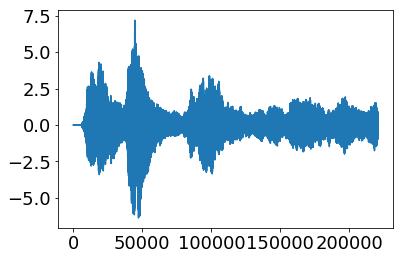

In [77]:
# Feedback Delay Network by T.Lokki

'''
Matlab version from DAFX pg.170

% delaynetwork.m
% Author: T. Lokki 
fs=44100;
gain=0.97;

% Create an impulse
x = zeros(1,1*fs); 
x(1) = 1; 
y = zeros(1,fs);
b = [1 1 1 1];
c = [0.8 0.8 0.8 0.8];

% Feedback matrix
a(1,:)=[0 1 1 0]; 
a(2,:)=[-1 0 0 -1]; 
a(3,:)=[1 0 0 -1]; 
a(4,:)=[0 1 -1 0]; 
a2=a*(1/sqrt(2)) * gain;

% Delay lines, use prime

m=[149 211 263 293]'; 
z1=zeros(1,max(max(m))); 
z2=zeros(1,max(max(m))); 
z3=zeros(1,max(max(m))); 
z4=zeros(1,max(max(m)));

for n = 1:length(y)
    tmp = [z1(m(1)) z2(m(2)) z3(m(3)) z4(m(4))]; 
    y(n) = x(n) + c(1)*z1(m(1)) + c(2)*z2(m(2)) + c(3)*z3(m(3)) + c(4)*z4(m(4));
    z1 = [(x(n)*b(1) + tmp*a2(1,:)') z1(1:length(z1)-1)]; 
    z2 = [(x(n)*b(2) + tmp*a2(2,:)') z2(1:length(z2)-1)]; 
    z3 = [(x(n)*b(3) + tmp*a2(3,:)') z3(1:length(z3)-1)]; 
    z4 = [(x(n)*b(4) + tmp*a2(4,:)') z4(1:length(z4)-1)];
end 

plot(y)
'''

T60s = [0.7, 0.14, 3.0, 0.6]
fs = 44100
gain = 0.97
chunk = 4410

violin = read_wave(config.paths.data[2])
x = violin.ys.copy()
y = np.zeros_like(x)
b = np.ones(4)
c = np.ones(4) * 0.8

A = np.array([
    [0,1,1,0],
    [-1,0,0,-1],
    [1,0,0,-1],
    [0,1,-1,0]
])
A = A / np.sqrt(2) * gain

m = np.array([149, 211, 263, 293]).T;
z = np.zeros((4, np.max(m)));

for n in range(y.size):
    tmp = np.array([
        z[0,m[0]-1], 
        z[1,m[1]-1], 
        z[2,m[2]-1], 
        z[3,m[3]-1], 
    ])
    
    y[n] = x[n] + c[0] * z[0][m[0]-1] \
                + c[1] * z[1][m[1]-1] \
                + c[2] * z[2][m[2]-1] \
                + c[3] * z[3][m[3]-1] 
    z[:,1:] = z[:,:np.max(m)-1]
    z[:,0] = x[n] * b + (tmp @ A)
#     z[0,0] = x[n] * b[0] + (tmp @ A[0])
#     z[1,0] = x[n] * b[1] + (tmp @ A[1])
#     z[2,0] = x[n] * b[2] + (tmp @ A[2])
#     z[3,0] = x[n] * b[3] + (tmp @ A[3])
    
plt.plot(y)
violin.ys = y
violin.make_audio()

In [78]:
from scipy.io import wavfile

In [79]:
wavfile.write("violin_fdn.wav", 44100, y)

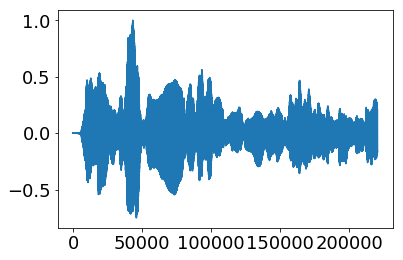

In [74]:
plt.plot(y_reference)

## References

- DAFX: Digital Audio Effects  by John Wiley